# XOR probléma megtanítása MLP hálóval
### + L1/L2 regularizáció, Nesterov-momentum, dropout, mini-batch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

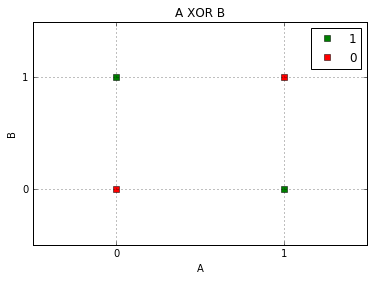

In [2]:
#abrazolas
true_x=np.array([1,0])
true_y=np.array([0,1])
false_x=np.array([0,1])
false_y=np.array([0,1])
plt.plot(true_x,true_y,"gs",label="1");
plt.plot(false_x,false_y,"rs",label="0");
plt.xlim(-0.5,1.5)
plt.ylim(-0.5,1.5)
plt.xticks([0,1]);
plt.yticks([0,1]);
plt.grid(True)
plt.title("A XOR B");
plt.xlabel("A");
plt.ylabel("B");
plt.legend(numpoints=1);

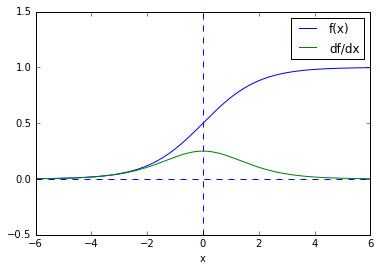

In [3]:
#aktivacios fuggveny es a derivaltja
def activation(x): return 1/(1+np.exp(-x))
def dactivation(x): return np.exp(-x)/((1+np.exp(-x))**2)
x=np.linspace(-6,6,200)
plt.plot(x,activation(x),label="f(x)");
plt.plot(x,dactivation(x),label="df/dx");
plt.xlim(-6,6)
plt.ylim(-0.5,1.5)
plt.axhline(0,linestyle="dashed");
plt.axvline(0,linestyle="dashed");
plt.xlabel("x");
plt.legend();

In [4]:
#univerzalis MultiLevel Perceptron osztaly
#argumentumok: (bemenetek, rejtett retegek neuronszamai (dinamikus!), kimenetek)
class MLP:
    def __init__(self,*args): #"konstruktor"
        np.random.seed(123)
        self.shape=args
        n=len(args)
        #retegek
        self.layers=[]
        self.layers.append(np.ones(self.shape[0]+1)) #bemeneti reteg (+1 bias)
        for i in range(1,n): #rejtett retegek + kimeneti reteg
            self.layers.append(np.ones(self.shape[i]))
        #sulymatrixok
        self.weights=[]
        for i in range(n-1):
            self.weights.append(np.empty([self.layers[i].size,self.layers[i+1].size]))
        self.dw=[0,]*len(self.weights) #a sulyok elozo modositasai (momentummodszerhez)
        self.reset()

    def reset(self): #sulyok inicializalasa
        for i in range(len(self.weights)):
            Z=np.random.random([self.layers[i].size,self.layers[i+1].size])
            self.weights[i]=2*Z-1 #[-1;1[ intervallumba skalazas

    def propagate_forward(self,data,p_dropout=0): #a halozat futtatasa a megadott adatra
        self.layers[0][0:-1]=data
        for i in range(1,len(self.shape)):
            if((p_dropout>0) and (i<len(self.shape)-1)): #csak a rejtett retegekben van dropout
                mask=np.random.binomial([np.ones(self.layers[i].shape[0])],1-p_dropout)[0]
            else:
                mask=np.ones(self.layers[i].shape[0])
            self.layers[i]=activation(np.dot(self.layers[i-1],self.weights[i-1]))*mask
        return self.layers[-1]

    def propagate_backward(self,target): #hibavisszaterjesztes
        deltas=[]
        error=self.layers[-1]-target
        delta=error*dactivation(np.dot(self.layers[-2],self.weights[-1]))
        deltas.append(delta)
        for i in range(len(self.shape)-2,0,-1):
            delta=(np.dot(deltas[0],self.weights[i].T) *
                   dactivation(np.dot(self.layers[i-1],self.weights[i-1])))
            deltas.insert(0,delta)
        grads=[]
        for i in range(len(self.weights)):
            layer=np.atleast_2d(self.layers[i])
            delta=np.atleast_2d(deltas[i])
            grads.append(np.dot(layer.T,delta))
        return grads
    
    def update_weights(self,grads,lrate,nest,momentum,reg,reg_lambda): #sulymodositas
        for i in range(len(self.weights)):
            grad=np.atleast_2d(grads[i])
            if(reg==1): #L1 regularizacio
                regterm=-lrate*reg_lambda*np.sign(self.weights[i])
            elif(reg==2): #L2 regularizacio
                regterm=-lrate*reg_lambda*self.weights[i]
            else: #nincs regularizacio
                regterm=0
            if(nest): #Nesterov-momentum
                momterm=momentum*(momentum*self.dw[i]-lrate*grad)
            else: #sima momentum
                momterm=momentum*self.dw[i]
            dw=-lrate*grad+regterm+momterm
            self.weights[i]+=dw
            self.dw[i]=dw

In [5]:
#a halo tanitasa mini-batch modszerrel
def learn(network,samples,epochs,lrate,nest,momentum,reg,reg_lambda,p_dropout,batchSize):
    if(batchSize>samples["input"].shape[0]):
        print("Batch meret nagyobb az adatok szamanal!")
        return
    for i in range(epochs):
        shuffle=np.random.permutation(samples["input"].shape[0]) #megkeverjuk az adatokat
        for k in range(0,samples["input"].shape[0],batchSize): #vegiglepkedunk a batch-eken
            grad=[np.zeros(w.shape) for w in network.weights]
            for j in range(k,np.minimum(k+batchSize,samples["input"].shape[0])): #egy batch futtatasa
                network.propagate_forward(samples["input"][shuffle[j]],p_dropout)
                g=network.propagate_backward(samples["output"][shuffle[j]])
                grad=[grad[n]+g[n]/batchSize for n in range(len(network.weights))] #kumulalt gradiens
            network.update_weights(grad,lrate,nest,momentum,reg,reg_lambda) #batch vegen korrigalunk
    print("Tanitas kesz!")
    out=np.empty(samples.size)
    for i in range(samples.size):
        out[i]=network.propagate_forward(samples["input"][i])
        print("%d. bemenet: %s, elvart kimenet: %.4f, valos kimenet: %.4f" %
              (i+1,str(samples["input"][i]),samples["output"][i],out[i]))

In [6]:
#tanito adatok
samples=np.empty(4,dtype=[("input",float,2),("output",float,1)])
samples[0]=[0,0],0
samples[1]=[1,0],1
samples[2]=[0,1],1
samples[3]=[1,1],0

In [7]:
network=MLP(2,10,1) #halo 2 bemenettel, egy 10 neuronos rejtett reteggel, 1 kimenettel
epochs=2000 #epoch szam
lrate=2.5 #tanulasi rata
nest=True #Nesterov-momentum (True) vagy sima (False)
momentum=0.9 #momentum
reg=2 #regularizacio tipusa (nincs/L1/L2)
reg_lambda=1e-5 #regularizacios parameter
p_dropout=0.5 #dropout valoszinuseg
batchSize=2 #batch merete
learn(network,samples,epochs,lrate,nest,momentum,reg,reg_lambda,p_dropout,batchSize) #tanitas

Tanitas kesz!
1. bemenet: [ 0.  0.], elvart kimenet: 0.0000, valos kimenet: 0.0000
2. bemenet: [ 1.  0.], elvart kimenet: 1.0000, valos kimenet: 0.9974
3. bemenet: [ 0.  1.], elvart kimenet: 1.0000, valos kimenet: 0.9972
4. bemenet: [ 1.  1.], elvart kimenet: 0.0000, valos kimenet: 0.0000


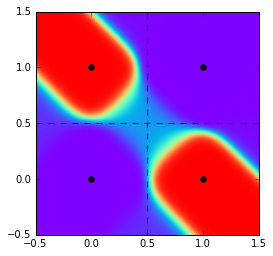

In [8]:
#a halo mukodesenek abrazolasa
out_image=np.empty([101,101])
for i,x in enumerate(np.linspace(-0.5,1.5,101)):
    for j,y in enumerate(np.linspace(-0.5,1.5,101)):
        out_image[i,j]=network.propagate_forward([x,y]);
plt.imshow(out_image.T[::-1],extent=[-0.5,1.5,-0.5,1.5],cmap=cm.rainbow);
plt.plot(true_x,true_y,"ko");
plt.plot(false_x,false_y,"ko");
plt.axhline(0.5,linestyle="dashed");
plt.axvline(0.5,linestyle="dashed");
plt.xlim(-0.5,1.5);
plt.ylim(-0.5,1.5);